## Домашнее задание по теме "Оценка точности модели, переобучение, регуляризация"

### Подготавливаем данные

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import  matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('affair_data.csv')
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


Формируем набор признаков и целевую переменную

In [3]:
X = data[data.columns[:-1]]
X.head(2)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0


In [4]:
Y = data['affair']

In [5]:
model = LogisticRegression()

Разбиваем данные на обучающую и тестовую выборки в соотношении 70 / 30

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

Обучаем модель

In [7]:
model.fit(X_train, Y_train)

LogisticRegression()

Получаем прогнозные значения модели (переменная predictions)

In [8]:
predictions = model.predict_proba(X_test)

In [9]:
predictions[:2]

array([[0.37442487, 0.62557513],
       [0.92523133, 0.07476867]])

### ROC

In [10]:
# универсальная функция - всё в одном флаконе
def roc_pr(predictions, values, threshold):
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative
    eps = 10e-9

    for predicted_prob, actual in zip( predictions, values ):    
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0
    
        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
    
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp + eps) # чтобы избежать деления на ноль
    recall = tp / (tp + fn)
    return tpr, fpr, precision, recall

In [11]:
# посчитаем ROC-кривую (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve
# получаем значения false и true positive rate для различных значений порога
fpr, tpr, thres = roc_curve( Y_test, predictions[:, 1] )
for line in zip( tpr[:10], fpr[:10], thres[:10] ):
    print( line )

(0.0, 0.0, 1.9292091232671758)
(0.0016474464579901153, 0.0, 0.9292091232671756)
(0.008237232289950576, 0.0, 0.89998862795351)
(0.008237232289950576, 0.0007674597083653108, 0.8977304698527878)
(0.019769357495881382, 0.0007674597083653108, 0.8650840097292727)
(0.019769357495881382, 0.0030698388334612432, 0.8547129971134584)
(0.023064250411861616, 0.0030698388334612432, 0.8544826965581638)
(0.023064250411861616, 0.003837298541826554, 0.8521926884372871)
(0.03130148270181219, 0.003837298541826554, 0.8338303480746599)
(0.03130148270181219, 0.004604758250191865, 0.8336073228587285)


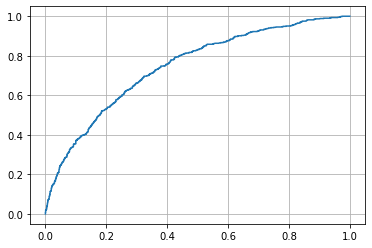

In [12]:
plt.plot( fpr, tpr )
plt.grid()

In [13]:
# считаем tpr, fpr вручную
my_tpr = []
my_fpr = []
for threshold in thres:
    tpr_fpr = roc_pr(predictions[:, 1], Y_test, threshold)
    my_tpr.append(tpr_fpr[0])
    my_fpr.append(tpr_fpr[1])

In [14]:
for i in range(10):
    print(my_tpr[i], my_fpr[i], thres[i])

0.0 0.0 1.9292091232671758
0.0016474464579901153 0.0 0.9292091232671756
0.008237232289950576 0.0 0.89998862795351
0.008237232289950576 0.0007674597083653108 0.8977304698527878
0.019769357495881382 0.0007674597083653108 0.8650840097292727
0.019769357495881382 0.0030698388334612432 0.8547129971134584
0.023064250411861616 0.0030698388334612432 0.8544826965581638
0.023064250411861616 0.003837298541826554 0.8521926884372871
0.03130148270181219 0.003837298541826554 0.8338303480746599
0.03130148270181219 0.004604758250191865 0.8336073228587285


Строим нашу roc-кривую:

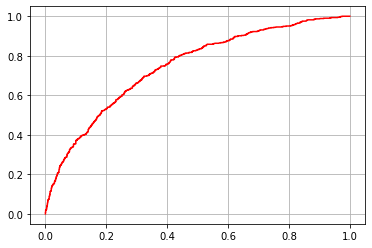

In [15]:
plt.plot(my_fpr, my_tpr, c='r')
plt.grid()

In [16]:
from sklearn.metrics import roc_auc_score

In [17]:
roc_auc_score( Y_test, predictions[:, 1] )

0.7451629176618145

In [18]:
from sklearn.metrics import auc

In [19]:
auc( fpr, tpr )

0.7451629176618145

Проверям auc для нашего решения:

In [20]:
auc(my_fpr, my_tpr)

0.7451629176618145

### Precision-recall

In [21]:
# метод для построения графика precision-recall
from sklearn.metrics import precision_recall_curve

In [22]:
pr, re, thres = precision_recall_curve( Y_test, predictions[:, 1] )

In [23]:
pr.shape, thres.shape

((1667,), (1666,))

In [24]:
# посмотрим что получилось
for line in zip( pr[:10], re[:10], thres[:10] ):
    print( line )

(0.32338838572189665, 1.0, 0.0758292330802056)
(0.3230277185501066, 0.9983525535420099, 0.07617596140664248)
(0.3232, 0.9983525535420099, 0.07800501924779417)
(0.3233724653148346, 0.9983525535420099, 0.07833731269232783)
(0.32354511478910836, 0.9983525535420099, 0.07858652772450929)
(0.32371794871794873, 0.9983525535420099, 0.07969132490711633)
(0.3238909673971138, 0.9983525535420099, 0.07987106602836637)
(0.3240641711229946, 0.9983525535420099, 0.0803136749557333)
(0.32423756019261635, 0.9983525535420099, 0.08053860441486359)
(0.3238758029978587, 0.9967051070840197, 0.0806879714975657)


(0.0, 1.0)

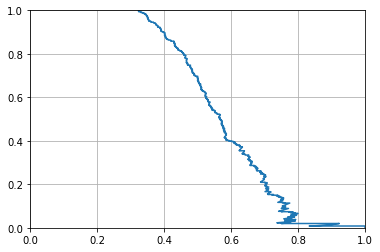

In [25]:
plt.plot(pr,re)
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)

Вычислим самостоятельно:

In [30]:
# считаем precision, recall вручную
my_pr = []
my_re = []
for threshold in thres:
    pr_re = roc_pr(predictions[:, 1], Y_test, threshold)
    my_pr.append(pr_re[2])
    my_re.append(pr_re[3])

In [31]:
for i in range(10):
    print(my_pr[i], my_re[i], thres[i])

0.32338838572017375 1.0 0.0758292330802056
0.32302771854838475 0.9983525535420099 0.07617596140664248
0.3231999999982763 0.9983525535420099 0.07800501924779417
0.32337246531310904 0.9983525535420099 0.07833731269232783
0.32354511478738096 0.9983525535420099 0.07858652772450929
0.32371794871621945 0.9983525535420099 0.07969132490711633
0.32389096739538276 0.9983525535420099 0.07987106602836637
0.32406417112126173 0.9983525535420099 0.0803136749557333
0.32423756019088157 0.9983525535420099 0.08053860441486359
0.3238758029961249 0.9967051070840197 0.0806879714975657


(0.0, 1.0)

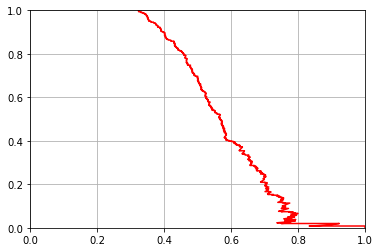

In [33]:
plt.plot(my_pr, my_re, c='r')
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)

Видим, что кривая precision-recall имеет такой же вид, как и полученная с помощью библиотечных методов.